# Customer Segmentation

The goal is to segment customers effectively based on their banking behavior and preferences.

# Preparing the Data
## Importing packages

In [547]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from scipy.stats import zscore

import os

## Reading in data

In [548]:
project_root = os.getcwd()  # Assumes script runs from project root

# Define the path to the processed data folder
data_path = os.path.join(project_root, "..", "..", "data", "processed")

# Load the CSV files
customer_df = pd.read_csv(os.path.join(data_path, "customer.csv"))
digital_usage_df = pd.read_csv(os.path.join(data_path, "digital_usage.csv"))
transactions_df = pd.read_csv(os.path.join(data_path, "transactions.csv"))
products_df = pd.read_csv(os.path.join(data_path, "products_owned.csv"))

## Ensure dates are in the right format

In [549]:
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])

## Creating interaction terms

### Transaction Table
To capture recent customer activity, the script calculates the number of days since each customer’s last transaction from our reference date (2025-01-01). We also computed the average transaction amount per customer. The average is calculated as total amount divided by count, with safeguards in place to handle missing values or potential division by zero.

In [550]:
# Days from last transaction
latest_transaction = transactions_df.groupby("customer_id")["transaction_date"].max().reset_index()
latest_transaction["transaction_date"] = pd.to_datetime(latest_transaction["transaction_date"]) 
reference_date = pd.to_datetime("2025-01-01")
latest_transaction["days_from_last_transaction"] = (reference_date - latest_transaction["transaction_date"]).dt.days
latest_transaction = latest_transaction[["customer_id", "days_from_last_transaction"]]
### Calculate avg_transaction_amt per customer
transaction_summary = transactions_df.groupby("customer_id").agg(total_transaction_amt=("transaction_amt", "sum"),num_transactions=("transaction_id", "count")).reset_index()
transaction_summary["avg_transaction_amt"] = transaction_summary["total_transaction_amt"] / transaction_summary["num_transactions"]
transaction_summary["avg_transaction_amt"] = transaction_summary["avg_transaction_amt"].replace([np.inf, -np.inf], 0).fillna(0)
transaction_summary = transaction_summary[["customer_id", "avg_transaction_amt", "num_transactions"]]


### Digital Usage table

This code computes a digital engagement score for each customer based on their online activity.
    
Combine both metrics into a weighted score:

- Logins (70%) contribute more since frequent logins indicate active engagement.
- Session time (30%) contributes less but still matters.

In [551]:
# Calculate digital engagement score
scaler = StandardScaler()
digital_usage_df["normalized_logins"] = scaler.fit_transform(digital_usage_df[["mobile_logins_wk", "web_logins_wk"]].sum(axis=1).values.reshape(-1, 1))
digital_usage_df["normalized_session_time"] = scaler.fit_transform(digital_usage_df[["avg_mobile_time", "avg_web_time"]].sum(axis=1).values.reshape(-1, 1))
digital_usage_df["digital_engagement_score"] = (digital_usage_df["normalized_logins"] * 0.7 +digital_usage_df["normalized_session_time"] * 0.3)
# Correct aggregation step
digital_engagement = digital_usage_df.groupby("customer_id", as_index=False)["digital_engagement_score"].mean()

### Products table

This code calculates the total number of financial products a customer owns from the bank, which helps measure their relationship with the bank.

In [552]:
# Total products owned
products_df["total_products_owned"] = products_df.iloc[:, 1:].sum(axis=1)
products_summary = products_df[["customer_id", "total_products_owned"]]

### Customer table

This code selects relevant financial and behavioral attributes from the customer dataset to be used in segmentation.

In [553]:
## Extracting relevant columns from customer table
customer_features = ['customer_id', 'income', 'balance', 'customer_lifetime_value', 'debt', 'tenure', 'default']
customer_subset_df = customer_df[customer_features]

## Merging datasets

In [554]:
## MERGE DATASETS
df = customer_subset_df.merge(latest_transaction, on="customer_id", how="left")
df = df.merge(transaction_summary[["customer_id", "avg_transaction_amt", "num_transactions"]], on="customer_id", how="left")
df = df.merge(digital_engagement[["customer_id", "digital_engagement_score"]], on="customer_id", how="left")
df = df.merge(products_df[["customer_id", "total_products_owned"]], on="customer_id", how="left")

# Insert another interaction term (transaction freq)
# Since data only avail from 2023-2024, transactions before 2023 for those with tenure >24 months not consider
df["effective_tenure"] = df["tenure"].clip(upper=24)
df["transaction_freq"] = df["num_transactions"] / df["effective_tenure"]
df["transaction_freq"] = df["transaction_freq"].replace([np.inf, -np.inf], 0).fillna(0)
df.drop(columns=["effective_tenure"], inplace=True)

In [555]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 4000 non-null   int64  
 1   income                      4000 non-null   float64
 2   balance                     4000 non-null   float64
 3   customer_lifetime_value     4000 non-null   float64
 4   debt                        4000 non-null   float64
 5   tenure                      4000 non-null   int64  
 6   default                     4000 non-null   int64  
 7   days_from_last_transaction  1853 non-null   float64
 8   avg_transaction_amt         1853 non-null   float64
 9   num_transactions            1853 non-null   float64
 10  digital_engagement_score    3981 non-null   float64
 11  total_products_owned        4000 non-null   int64  
 12  transaction_freq            4000 non-null   float64
dtypes: float64(9), int64(4)
memory us

In [556]:
print(df.isnull().sum())

customer_id                      0
income                           0
balance                          0
customer_lifetime_value          0
debt                             0
tenure                           0
default                          0
days_from_last_transaction    2147
avg_transaction_amt           2147
num_transactions              2147
digital_engagement_score        19
total_products_owned             0
transaction_freq                 0
dtype: int64


## Handling missing values

Missing values are handled carefully based on the meaning of each feature:

1. `Digital engagement score``: Only 19 customers had missing values, so we impute using the mean to preserve overall engagement trends.

2. `Transaction-related features``:  
   - If a customer has no transaction records, we assume:
     - `avg_transaction_amt` = 0 (no spending)
     - `num_transactions` = 0 (no activity)
     - `transaction_freq` = 0 (no frequency)
   - For `days_from_last_transaction`, we assign a high but reasonable value — the current max value plus a 30-day buffer — to reflect inactivity without skewing the scale too far.

This targeted approach ensures that missing data is handled logically while minimizing distortion of actual customer behavior.


In [557]:
## HANDLING MISSING VALUES
### engagement score only has 19 missing values -> fill with mean
df["digital_engagement_score"].fillna(df["digital_engagement_score"].mean(), inplace=True)
### no transaction record (we set transactions to be 0)
df["avg_transaction_amt"].fillna(0, inplace=True)
df["transaction_freq"].fillna(0, inplace=True)
df["num_transactions"].fillna(0, inplace=True)
### some did not do transactions. we set the days from last transaction to be a high but not too extreme value. We add a month of buffer
df["days_from_last_transaction"].fillna(df["days_from_last_transaction"].max() + 30, inplace=True)

/var/folders/wc/5cwlt66x6d12kf_tz4qkd_580000gn/T/ipykernel_42667/3874435748.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["digital_engagement_score"].fillna(df["digital_engagement_score"].mean(), inplace=True)
/var/folders/wc/5cwlt66x6d12kf_tz4qkd_580000gn/T/ipykernel_42667/3874435748.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate 

In [558]:
print(df.isnull().sum())

customer_id                   0
income                        0
balance                       0
customer_lifetime_value       0
debt                          0
tenure                        0
default                       0
days_from_last_transaction    0
avg_transaction_amt           0
num_transactions              0
digital_engagement_score      0
total_products_owned          0
transaction_freq              0
dtype: int64


# Check for outliers

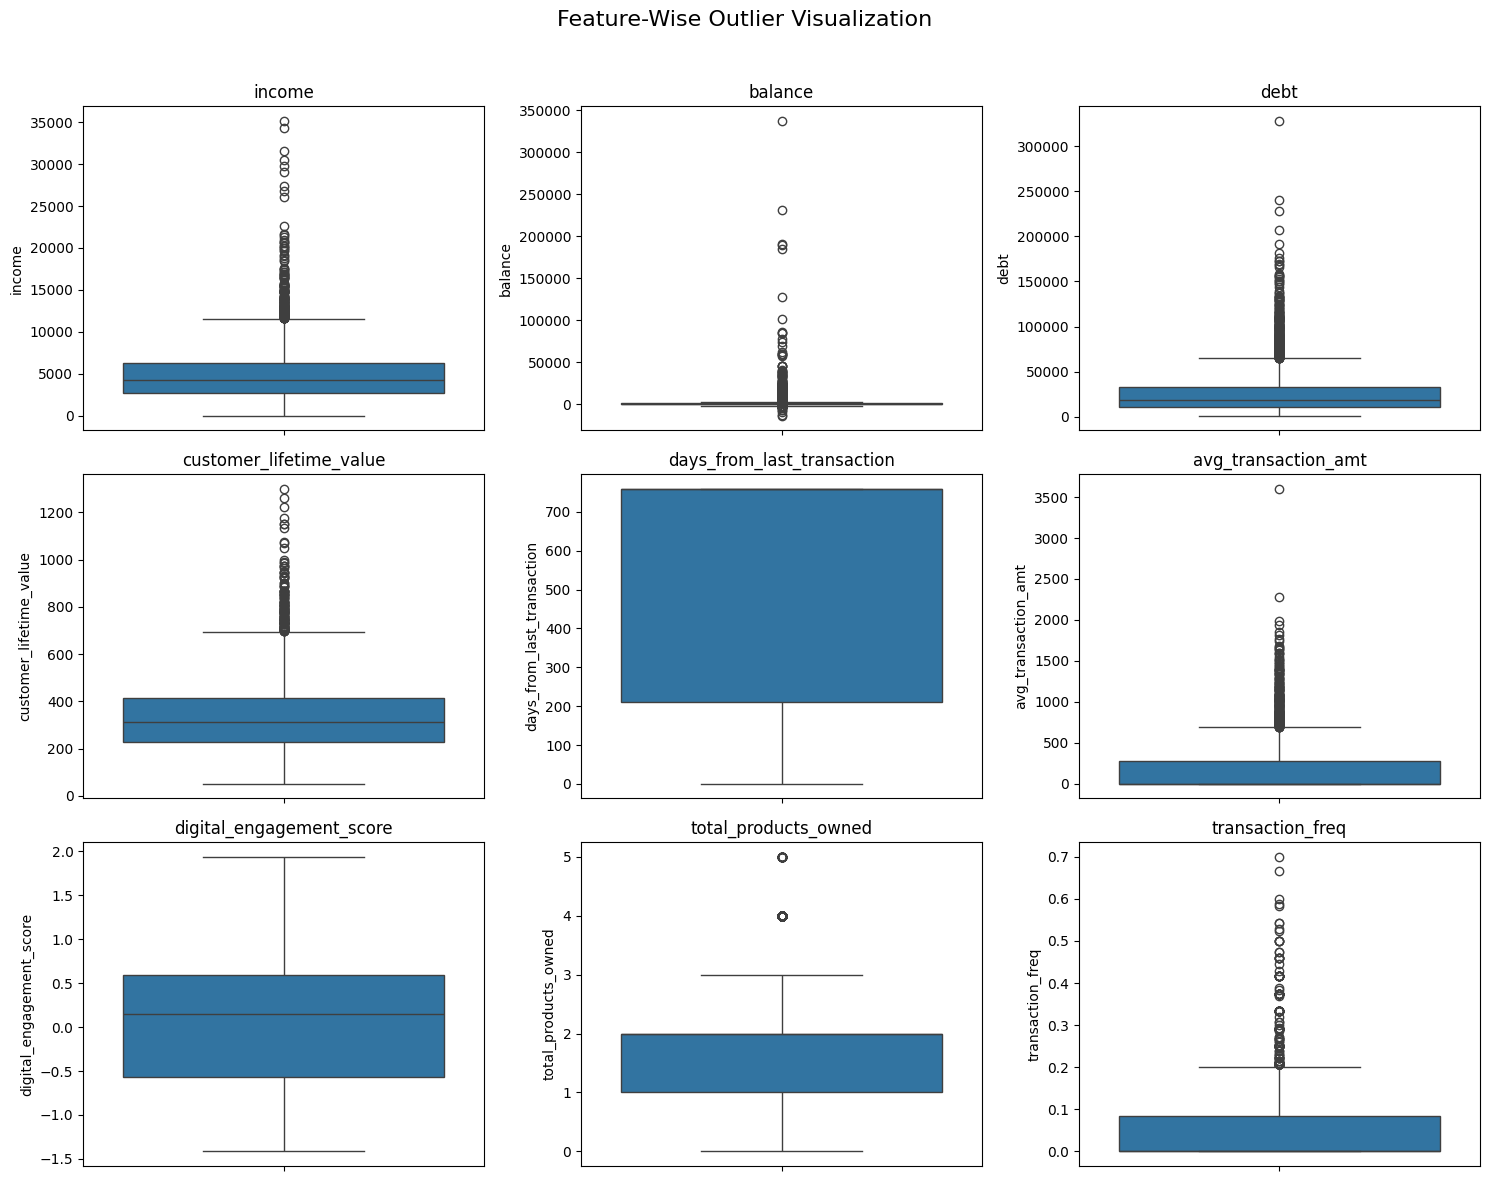

In [559]:
features_to_scale = [ "income", "balance", "debt", "customer_lifetime_value","days_from_last_transaction", "avg_transaction_amt","digital_engagement_score", "total_products_owned", "transaction_freq"]
# Check for outliers
# Create 3x3 grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Feature-Wise Outlier Visualization", fontsize=16)
axes = axes.flatten()
# Plot boxplots
for i, feature in enumerate(features_to_scale):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(feature)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [560]:
# Define function to count outliers using Z-score method
def count_outliers_zscore(df, threshold=3):
    outlier_counts = {}

    for col in df.select_dtypes(include=[np.number]): 
        z_scores = np.abs(zscore(df[col])) 
        num_outliers = (z_scores > threshold).sum()
        outlier_counts[col] = num_outliers

    return pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["Outlier Count"])


# Apply to dataset
outliers_zscore_df = count_outliers_zscore(df)
print(outliers_zscore_df)


                            Outlier Count
customer_id                             0
income                                 60
balance                                38
customer_lifetime_value                55
debt                                   89
tenure                                 16
default                                 0
days_from_last_transaction              0
avg_transaction_amt                    83
num_transactions                       68
digital_engagement_score                0
total_products_owned                   30
transaction_freq                       76


# Standardizing

To prepare features for clustering, we first applied **winsorization** to cap extreme outliers. 

- Features like `customer_lifetime_value`, `avg_transaction_amt`, and `transaction_freq` were lest skewed, so we applied **1% winsorization** (limits = `[0.0, 0.01]`).
- Wealth-related features like `income`, `balance`, and `debt` were more skewed, so we applied a stronger **10% winsorization** to reduce the influence of extreme values (limits = `[0.05, 0.10]`).

After capping outliers, we applied two types of scaling:

1. **RobustScaler** for `robust_features`  
   This scaler centers the median at 0 and scales based on the interquartile range (IQR), making it less sensitive to outliers than StandardScaler. It's ideal for features with residual skew even after winsorization.

2. **StandardScaler** for `standard_features`  
   This scales data to have a mean of 0 and a standard deviation of 1. It's used on features like `days_from_last_transaction`, `digital_engagement_score`, and `total_products_owned`, which are more normally distributed and less impacted by outliers.

This preprocessing ensures fair feature contribution to the clustering algorithm.

In [561]:
## STANDARDIZING FOR K-MEANS CLUSTERING
# Features that need Robust scaling 
robust_features = ["income", "balance", "debt", "customer_lifetime_value",  "avg_transaction_amt", "transaction_freq"]

# Heavily skewed → higher winsorization
heavy_outliers = ["income", "balance", "debt"]
for col in heavy_outliers:
    df[col] = pd.Series(winsorize(df[col].to_numpy(), limits=[0.05, 0.10])).astype(float)

# Moderate outliers → light winsorization
moderate_outliers = ["customer_lifetime_value", "avg_transaction_amt", "transaction_freq"]
for col in moderate_outliers:
    df[col] = pd.Series(winsorize(df[col].to_numpy(), limits=[0.0, 0.01])).astype(float)



# Features that need Standard scaling (normally distributed)
standard_features = ["days_from_last_transaction", "digital_engagement_score", "total_products_owned"]

# Apply RobustScaler
scalerrobust =  RobustScaler()
df_scaled = df.copy()
df_scaled[robust_features] = scalerrobust.fit_transform(df[robust_features])

# Apply StandardScaler
scaler_standard = StandardScaler()
df_scaled[standard_features] = scaler_standard.fit_transform(df[standard_features])

# PCA Analysis

This code performs Principal Component Analysis (PCA) to analyze how much variance each feature contributes to the dataset. explained_variance_ratio_: Measures how much variance each principal component captures.

In [562]:
# Apply PCA
pca = PCA(n_components=len(features_to_scale))  # Keep all components
df_pca = pca.fit_transform(df_scaled[features_to_scale])

# Convert to DataFrame
explained_variance = pd.DataFrame(
    pca.explained_variance_ratio_,
    index=features_to_scale,
    columns=["Explained Variance"]
)

# Print explained variance of each feature
print("\nPCA Explained Variance:\n", explained_variance.sort_values(by="Explained Variance", ascending=False))


PCA Explained Variance:
                             Explained Variance
income                                0.330845
balance                               0.201121
debt                                  0.132863
customer_lifetime_value               0.127235
days_from_last_transaction            0.079680
avg_transaction_amt                   0.063213
digital_engagement_score              0.036197
total_products_owned                  0.024265
transaction_freq                      0.004581


In [563]:
features = df.columns
print(features)

Index(['customer_id', 'income', 'balance', 'customer_lifetime_value', 'debt',
       'tenure', 'default', 'days_from_last_transaction',
       'avg_transaction_amt', 'num_transactions', 'digital_engagement_score',
       'total_products_owned', 'transaction_freq'],
      dtype='object')


# Modeling

## K-Means Clustering
We use k = 3 to segment the customers into 3 categories 
1. High value
2. Budget conscious
3. At risk / inactive customers

In [564]:
## K-MEANS CLUSTERING
optimal_k = 3
df_scaled["Cluster"] = KMeans(n_clusters= optimal_k,  init="k-means++", n_init=20, random_state=42).fit_predict(df_scaled[features_to_scale])
df["Cluster"] = df_scaled["Cluster"]

### Number of clients in each cluster

In [565]:
print(df["Cluster"].value_counts())

Cluster
1    2287
2    1297
0     416
Name: count, dtype: int64


# Evaluation: Silhouette Score
 This score shows how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [566]:
# Silhouette Score
silhouette_avg = silhouette_score(df_scaled[features_to_scale], df["Cluster"])
print(f"Silhouette Score = {silhouette_avg:.4f}")

Silhouette Score = 0.2336


Silhouette Score = 0.2336, indicating that while the segments have meaningful distinctions, there is moderate overlap between customer groups. Customer data typically includes heterogeneous characteristics (e.g., behavioral, transactional, demographic attributes) that naturally reduce clear separations between segments. The segments are designed based on business logic (engagement, spending, product usage),even if silhouette metrics aren't exceptionally high.

### Getting information about each cluster's mean of features

In [567]:
cluster_means = df_scaled.groupby("Cluster")[features_to_scale].mean()
print(cluster_means)

           income   balance      debt  customer_lifetime_value  \
Cluster                                                          
0        1.096870  2.152045  0.281576                 0.548329   
1        0.121799  0.461907  0.199057                 0.100251   
2       -0.167243 -0.035334  0.168231                 0.067268   

         days_from_last_transaction  avg_transaction_amt  \
Cluster                                                    
0                         -1.158732             2.770479   
1                          0.800823             0.039179   
2                         -1.040439             0.985565   

         digital_engagement_score  total_products_owned  transaction_freq  
Cluster                                                                    
0                        0.027024              0.126785          2.050743  
1                       -0.004964             -0.030528          0.033603  
2                        0.000086              0.013166         

## Cluster Labels
We assign higher weights for critical factors that define customer value:
- income (10%) → High value customers likely to be more financially healthy
- balance (10%) → Same reason as above
- customer_lifetime_value (15%) → Long-term revenue predictor.
- avg_transaction_amt (20%) → High-value customers spend more per transaction.
- digital_engagement_score (20%) → Engaged customers are more valuable.
- total_products_owned (20%) → Owning multiple products strengthens customer loyalty.
- transaction_freq (20%) → Frequent transactions signal active customers.



Penalty for inactivity:
- days_from_last_transaction (- 20%) → Longer inactivity lowers score.
Slight penalty for financial distress:
- debt (-5%) → High debt can indicate financial risk.

We assign segments dynamically based on rankings
- Top cluster = High-Value
- 2rd highest = Budget-Conscious
- Last = Inactive


In [568]:
cluster_means["score"] = (
    cluster_means["income"] * 0.1 + 
    cluster_means["balance"] * 0.1 + 
    cluster_means["debt"] * (-0.05) +  # Negative weight for financial distress
    cluster_means["customer_lifetime_value"] * 0.15 +  # Increased because CLV predicts revenue
    cluster_means["days_from_last_transaction"] * (-0.20) +  # Increased penalty for inactivity
    cluster_means["avg_transaction_amt"] * 0.20 +  # High-value customers spend more per transaction
    cluster_means["digital_engagement_score"] * 0.20 +  # More engagement means higher retention
    cluster_means["total_products_owned"] * 0.20 +  # Owning more products = stronger banking relationship
    cluster_means["transaction_freq"] * 0.20  # Higher impact because frequent usage matters
)


# Rank Clusters Based on Score (Descending)
sorted_clusters = cluster_means["score"].sort_values(ascending=False).index.tolist()

# Assign Segments Based on Rank
dynamic_segment_mapping = {
    sorted_clusters[0]: "High-value",
    sorted_clusters[1]: "Budget-conscious",
    sorted_clusters[2]: "At risk / inactive customers"
}

# Print cluster rankings before applying
print("\nCluster Ranking by Score (Best to Worst):")
for i, cluster in enumerate(sorted_clusters):
    print(f"Rank {i+1}: Cluster {cluster} → {dynamic_segment_mapping[cluster]}")


Cluster Ranking by Score (Best to Worst):
Rank 1: Cluster 0 → High-value
Rank 2: Cluster 2 → Budget-conscious
Rank 3: Cluster 1 → At risk / inactive customers


# Creating DF with the segments

In [569]:
# Apply Mapping to DataFrame
df["Segment"] = df["Cluster"].map(dynamic_segment_mapping)
print(df["Segment"].value_counts())

Segment
At risk / inactive customers    2287
Budget-conscious                1297
High-value                       416
Name: count, dtype: int64


In [570]:
df_final = df[["customer_id", "Segment"]]
print(df_final.head())

   customer_id                       Segment
0          449  At risk / inactive customers
1          309  At risk / inactive customers
2           78  At risk / inactive customers
3          258              Budget-conscious
4          151              Budget-conscious


In [571]:
# Getting information of these segments
segment_means = df.groupby("Segment")[features_to_scale].mean()
# Display the results
print("Mean of original features per segment:")
print(segment_means)

Mean of original features per segment:
                                   income      balance          debt  \
Segment                                                                
At risk / inactive customers  4638.945138   938.703629  23223.279134   
Budget-conscious              3617.939314   309.687664  22556.080100   
High-value                    8083.261731  3076.748894  25009.298894   

                              customer_lifetime_value  \
Segment                                                 
At risk / inactive customers               330.465982   
Budget-conscious                           324.298443   
High-value                                 414.252019   

                              days_from_last_transaction  avg_transaction_amt  \
Segment                                                                         
At risk / inactive customers                  749.586795            10.821415   
Budget-conscious                              214.720894           272.

## Creates csv table in under customer segmentation

In [572]:
df_final.to_csv("../customer_segments.csv", index=False)
print("Saved 'customer_segments.csv' with Customer ID & segment name")

Saved 'customer_segments.csv' with Customer ID & segment name
